In [15]:
#Segment 1
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()
warnings.filterwarnings('ignore')

TensorFlow Version 2.15.0


In [16]:
#Segment 2
image_size = 224
batch_size = 16
n_classes = 41

train_path = 'ORL_traindata'
test_path = 'ORL_testdata'

image_size = (224, 224)
#batch_size = 16

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

#test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 328 images belonging to 41 classes.
Found 82 images belonging to 41 classes.


### DATA AUGMENTATIONS

This code defines a function named data_augment that performs data augmentation on an input image using TensorFlow operations. Data augmentation is a technique commonly used in machine learning to artificially increase the size of the training dataset by applying various transformations to the original data. This helps improve the generalization and robustness of a model.

- The function takes an input image as its parameter.

- Two random probabilities, p_spatial and p_rotate, are generated using tf.random.uniform. These probabilities will be used to decide whether to apply spatial and rotation transformations, respectively.

- The image is randomly flipped horizontally and vertically using tf.image.random_flip_left_right and tf.image.random_flip_up_down.

- Based on the value of p_spatial, the image is transposed (flipped across its diagonal) with a probability of 25%.

- Based on the value of p_rotate, the image undergoes rotation transformations. There are three possible rotation angles: 90º, 180º, and 270º, each with a different probability.

- The augmented image is returned.

In [17]:
def data_augment(image):
    # Generate random probabilities for spatial and rotation transformations
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
     # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    
    # Apply spatial transformations based on random probability
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
        
    # Apply rotation transformations based on random probability
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
    # Return the augmented image    
    return image  
        
        

This function can be used as part of a data pipeline to apply random spatial and rotation augmentations to input images during training, thereby diversifying the training dataset and potentially improving the model's performance and generalization.

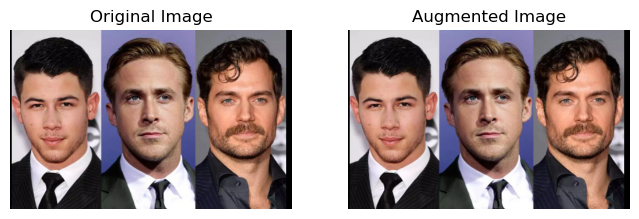

In [18]:
# Testing the above code

from PIL import Image  # Assuming you have the Pillow library installed

# Assuming you have an example image path
example_image_path = 'test_image2.jpg'

# Load the example image using PIL (Pillow)
example_image = Image.open(example_image_path)

# Convert the PIL image to a TensorFlow tensor
example_image_tensor = tf.convert_to_tensor(example_image)

# Apply data augmentation
augmented_image = data_augment(example_image_tensor)

# Convert the TensorFlow tensor back to a NumPy array for visualization
augmented_image_np = augmented_image.numpy()

# Plot the original and augmented images side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(example_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_image_np)
plt.axis('off')

plt.show()


#### Convert the PIL image to a TensorFlow tensor
Converting a PIL (Python Imaging Library) image to a TensorFlow tensor involves transforming the image data from the format used by PIL into a format compatible with TensorFlow. In TensorFlow, images are typically represented as tensors, which are multi-dimensional arrays that can be efficiently processed by machine learning models.



### DATA GENERATOR

This code is setting up data generators using TensorFlow's tf.keras.preprocessing.image.ImageDataGenerator for training, validation, and testing purposes.

#### Purpose of Data Generators
Data generators are used to efficiently load and preprocess data in batches, allowing the model to be trained on smaller chunks of data at a time. This is particularly useful when dealing with datasets that may not fit entirely into memory.

In this code, the tf.keras.preprocessing.image.ImageDataGenerator is used to create data generators for training, validation, and testing datasets. These generators apply samplewise centering, samplewise standard normalization, and include data augmentation using the data_augment function. This setup allows the model to be trained on augmented batches of data, improving its ability to generalize to new, unseen examples.

### Sample Images Visualisation

This code generates a grid of 3x5 images from the training data and visualizes them using Matplotlib. Each subplot contains an image, and the entire grid is displayed in a single figure. This is a common practice to inspect a small sample of training data and get a sense of the features and characteristics of the images the model is being trained on.

#### Use of this process

The code you provided is used for visualizing a grid of images sampled from the training data. 
The visualization code is a diagnostic tool to inspect and understand the data that the machine learning model is being trained on. It helps practitioners gain insights, verify data processing steps, and monitor the impact of data augmentation on the training dataset.

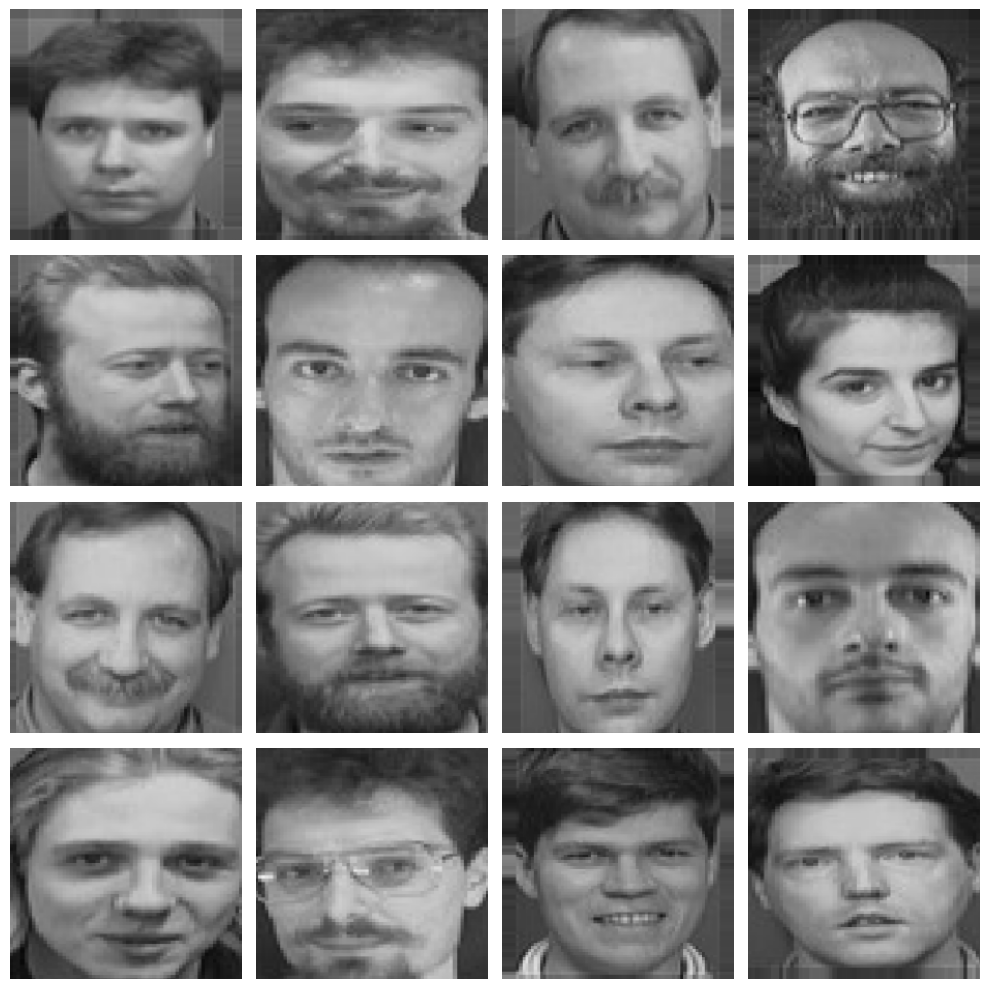

In [19]:
#Segment 3
# Extract the first 16 images from the first batch of the training generator
images = [train_gen[0][0][i] for i in range(16)]
# Create a 3x5 grid of subplots for displaying the images
fig, axes = plt.subplots(4, 4, figsize = (10, 10))

# Flatten the 3x5 grid of subplots into a 1D array for easier iteration
axes = axes.flatten()

# Iterate over each image and subplot to display the images
for img, ax in zip(images, axes):
    # Display the image on the subplot, reshaping it to the correct dimensions
    ax.imshow(img.reshape(image_size[0], image_size[1], 3))
     # Turn off axis labels for cleaner visualization
    ax.axis('off')

# Adjust the spacing between subplots to prevent overlapping
plt.tight_layout()
# Show the final grid of images
plt.show()

### MODEL HYPERPARAMETERS

This code defines hyperparameters for a transformer-based model.
#### Learning rate
It is a hyperparameter that determines the size of the step the optimizer takes during training. It influences how quickly or slowly a model learns.

Think of learning rate like the speed at which our computer learns. A smaller rate means it learns slowly but steadily, and a bigger rate means it learns quickly but might miss some details.

#### Weight decay
Weight decay is a regularization term that penalises large weights in the model. It helps prevent overfitting by discouraging complex models.

Weight decay is like telling the computer not to make things too complicated. It's a way to prevent our computer from overthinking and getting too fancy, which could make it confused when it sees new things.

#### Num_epochs
Number of epochs represents the number of times the entire dataset is passed through the model during training. One each epoch is one complete cycle through the entire training dataset.

Imagine our computer is reading a book about pictures. Each time it reads the entire book, that's called an epoch. So, reading the book only once means reading it for one epoch.

#### Patch_size
Patch size determines the size of the non-overlapping patches that are extracted from the input images. In the context of transformer models applied to images, the input image is divided into smaller patches.

If our computer is looking at a big picture, it might be easier to understand if it breaks the picture into small pieces. The size of each small piece is what we call a patch.

#### Num_patches
Calculates the number of patches that will be extracted from each input image. Its based on the image size and the specified patch size.

This line helps our computer figure out how many small pieces it can make from the big picture. It's like dividing the big picture into a grid of small pieces.

#### Projection_dim
Projection dimension is the size of the embeddings for each patch. 

When our computer looks at each small piece, it tries to understand it better by transforming it into a simpler form. The size of this simpler form is what we call the projection dimension.

#### Num_heads
Number of attention heads in the multi-head self-attention mechanism. More attention heads allow the model to focus on different aspects of the input data simultaneously.

This is a bit like having four sets of eyes. When our computer looks at something, it can focus on different parts at the same time. It helps it understand things more quickly.

#### Transfomer_units
Size of the transformer layers. These are the dimensions of the feedforward network inside each transformer block.

Inside our computer's brain, there are special layers called transformers. These layers have two parts, like two special rooms where our computer thinks about the picture in different ways.

#### Transformer_layers
Number of transformer layers stacked in the model. More layers can capture complex patterns but may increase computational requirements

Our computer doesn't just use one transformer layer, it uses many of them, like stacking multiple floors in a tall building. This helps it understand the picture in lots of different ways.

#### Mlp_head_units
Size of the dense layers of the final classifier. After processing the patches through the transformer layers, a multi-layer perceptron is often used for classification.
These dense layers reduce the dimensionality and make the final predictions.

Finally, our computer needs to make a guess about what it sees in the picture. These lines help it simplify its thoughts and make a decision. It's like the computer's way of saying, "I think I know what's in the picture!"

In [20]:
#Segment 4
# Learning rate for the optimizer
learning_rate = 0.001
# Weight decay is a regularization term that penalizes large weights in the model
weight_decay = 0.0001

# Number of training epochs, representing the number of passes through the entire training dataset
num_epochs = 1

# Size of the patches to be extracted from the input image
patch_size = 7 

img_size_int=image_size[0]
# Calculate the number of patches that will be extracted from each input image
num_patches = (img_size_int // patch_size) ** 2
# Projection dimension is the size of the embeddings for each patch
projection_dim = 64
# Number of attention heads in the multi-head self-attention mechanism
num_heads = 4
# Size of tranformer layers. These are the dimensions of the feedforward network inside each transformer block
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
# Number of tranformer layers stacked in the model
transformer_layers = 8

# Size of the dense layers of the final classifier. 
mlp_head_units = [56, 28] 

## Building the Model and its Components

### 1) Multilayer Perceptron (MLP)

#### Use of Multi-Layer Perceptron

Introducing non-linearity in a neural network model is crucial for its ability to learn complex patterns and relationships within data. Without non-linear activation functions, the model would effectively be limited to learning linear transformations of the input data. 

#### Functioning

When you use this mlp function with an input tensor x and specify the architecture with hidden_units and dropout_rate, it creates a multi-layer perceptron with dense layers using GELU(Gaussian Error Linear Unit) activation and dropout layers. This function can be part of a larger neural network architecture, especially in the context of deep learning models. It helps the model learn and understand patterns in the data.

- def mlp(x, hidden_units, dropout_rate):: This line defines a function named mlp that takes three parameters: x (an input tensor), hidden_units (a list of integers representing the number of units in each hidden layer), and dropout_rate (a parameter controlling dropout).

- x = L.Dense(units, activation=tf.nn.gelu)(x): This line adds a dense (fully connected) layer to the neural network. The units parameter determines the number of neurons in this layer. The GELU activation function is applied to introduce non-linearity

- x = L.Dropout(dropout_rate)(x): After the dense layer, a dropout layer is applied. Dropout randomly "drops out" some neurons during training, preventing overfitting.

- The return x statement indicates that the function returns the tensor x after all the layers have been applied. This tensor contains the output of the MLP. The specific interpretation of this output depends on the overall architecture of the neural network and the task it is designed to solve.

- In simpler terms, if you use this mlp function in a larger neural network, the value returned by the function would be the model's prediction or an intermediate representation of the input data after passing through the MLP layers.

In [21]:
#Segment 5
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x=L.Dense(units, activation=tf.nn.gelu)(x)
        x=L.Dropout(dropout_rate)(x)
    return x

### 2) Patch Creation Layer


The Patches class you provided is a well-structured custom layer in TensorFlow, and it is a good approach for creating patches from input images. This layer encapsulates the functionality of extracting patches using TensorFlow functions and allows for easy integration into a neural network model.

### Sample Images Patches Visualisation

The code takes an image, resizes it, extracts patches, and then visualizes both the original image and the individual patches in a grid. The printed information provides details about the sizes and numbers of elements involved in the process.

#### There are two methods we have used for patch creation and visualisation:
- Custom Layer Approach (Complex but better if we want to integrate with neural networks)
- Direct TensorFlow Functions Approach (More straightforward but not used for integration with neural networks)

### A) Custom Layer Approach

In [32]:

class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
       
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        batch_size = tf.shape(images)[0]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches


In [40]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        # Extract patches from the input images
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        return patches
    
    def compute_output_shape(self, input_shape):
        # Compute the shape of the output patches tensor
        batch_size = input_shape[0]
        image_height = input_shape[1]
        image_width = input_shape[2]
        num_channels = input_shape[3]
        patch_height = (image_height - self.patch_size + 1) // self.patch_size
        patch_width = (image_width - self.patch_size + 1) // self.patch_size
        return (batch_size, patch_height, patch_width, self.patch_size * self.patch_size * num_channels)


Image size: 224 X 224
Patch size: 84 X 84
Patches per image: 4
Elements per patch: 493920


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 493920 values, but the requested shape has 21168 [Op:Reshape]

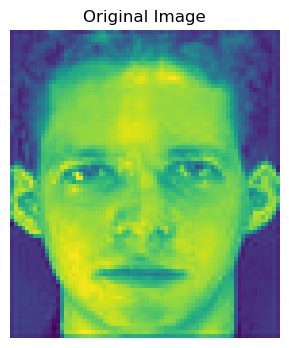

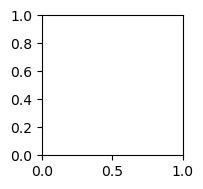

In [24]:
plt.figure(figsize=(4, 4))

#x = train_gen.next()
#image = x[0][0]

your_image_path = 'test_image.jpg'
image = plt.imread(your_image_path)

plt.title('Original Image')
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)
resized_image = tf.expand_dims(resized_image, axis=0)
#resized_image = tf.image.resize(
 #   tf.convert_to_tensor([image]), size=(image_size, image_size)
#)


#patches = Patches(patch_size)(resized_image)
patches = Patches(patch_size).call(resized_image)

print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

### B) Direct TensorFlow Functions Approach


#### Subplot function
The subplot function in Matplotlib is used to create a grid of subplots within a single figure. It allows you to arrange multiple plots or images in a structured manner.

It is a versatile function that helps you organize and present multiple plots in a single figure, making it a valuable tool in data visualization and analysis.

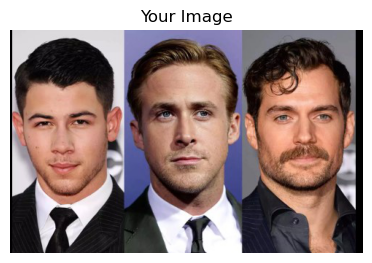

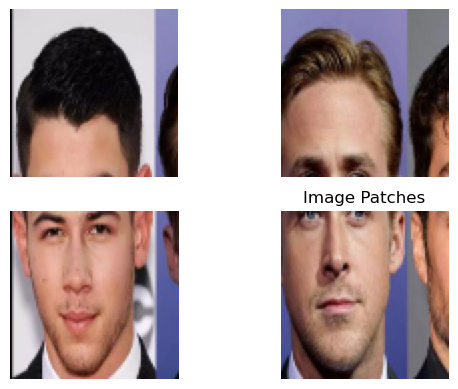

Image size: 224 X 224
Patch size: 84 X 84
Patches per image: 84
Elements per patch: 3


In [23]:
# Segment 6
#plt.figure(figsize=(4, 4))

# Using a single image from the dataset
#x = train_gen.next()
#image = x[0][0]

# Load your image
your_image_path = 'test_image2.jpg'
your_image = plt.imread(your_image_path)

# Parameters
image_size = 224
patch_size = 84  # Choose a patch size that divides evenly into the image size

# Resize the image to the desired size
resized_image = tf.image.resize(tf.convert_to_tensor([your_image]), size=(image_size, image_size))
#resized_image = tf.expand_dims(resized_image, axis=0)

# Create patches using TensorFlow functions
patches = tf.image.extract_patches(images=resized_image,
                                   sizes=[1, patch_size, patch_size, 1],
                                   strides=[1, patch_size, patch_size, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

# Calculate the total number of elements in the patches tensor
#total_elements = tf.reduce_prod(patches.shape)

# Calculate the number of elements needed to make the total elements a multiple of 2352
#elements_to_add = 2352 - (total_elements % 2352)

# Pad the patches tensor with zeros
#patches = tf.pad(patches, [[0, 0], [0, elements_to_add]])


# Reshape patches to have the same number of channels as the original image
patches = tf.reshape(patches, [-1, patch_size, patch_size, 3])

# Display original image and patches
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(your_image)
plt.title("Your Image")
plt.axis('off')

plt.show()

# Display patches
n = int(np.sqrt(patches.shape[0]))
plt.subplot(1, 2, 2)
for i, patch in enumerate(patches):
    ax = plt.subplot(n, n, i + 1)
    plt.imshow(patch.numpy().astype('uint8'))
    plt.axis('off')
plt.title("Image Patches")

plt.show()


print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')



### 3) Patch Encoding Layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [64]:
# Segment 7
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        # Initialize the PatchEncoder layer with the specified number of patches and projection dimension
        super(PatchEncoder, self).__init__()
        # Store the number of pacthes as an attribute
        self.num_patches = num_patches
        # Initialize a dense layer for linear transformation (projection) of input patches
        self.projection = L.Dense(units = projection_dim)
        # Initialize an embedding layer for positional information
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
    def call(self, patch):
        # Generate a tensor representing positions of patches from 0 to num_patches-1
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
       
        # Linearly transform (project) the input patch using the projection layer
        # Add the positional embedding obtained from the position_embedding layer
        projected_patch = self.projection(patch)
        position_embeddings = self.position_embedding(positions)
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        encoded = projected_patch + position_embeddings
        return encoded
    

## Building the ViT model

#### Image Patching
- Imagine cutting your picture into smaller pieces like a jigsaw puzzle

#### Self-Attention Mechanism
- Little super detectives (Multi-Head Attention) look at each piece very carefully and talk to each other about what they find

#### Transformer Blocks
- They are like super smart blocks that process the information about each puzzle piece

#### Feature Tensor
- All the smart blocks create a magical table of information that describes the puzzle pieces

#### Choosing how to present the information

#### Flattening 
- Smoothing out the table into a line

#### Global Average Pooling
- Taking an average 

#### Classifier Head
- A bossy leader looks at the smoothed information and makes the final decision about whats in the picture

#### Learnable Embedding
- Adding a speacial clue to help the smart blocks understand the puzzle better

#### Decision Making
- The leader makes the final decision about whats in the entire picture

#### Model Representation Choice
- The model decides wheter it wants to be present by Flattening or by Group Average Pooling

#### Project Dimensions
- Counting how many special dimensions(features) we have for each puzzle

#### Model Configuration Note
- The model writes a little note suggesting different options for presenting information

#### Number of Patches
- Counting how many puzzle pieces we have in the sequence

In [65]:
# Segment 8
def vision_transformer():
    # Input layer for the image data
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches from the input image
    patches = Patches(patch_size)(inputs)
    
    # Encode patches using PatchEncoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])
        
    # Create a [batch_size, projection_dim] tensor
    # Global Represntation
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add an additional MLP for classification
    # MLP Head for Classification
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Output layer for classification
    logits = L.Dense(n_classes)(features)
    
    # Create the final model.
    # Model Creation
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model
    

### Decay steps and decay function
 The use of decay steps and a decay function, especially in the context of learning rate scheduling, is crucial for optimizing the training process of neural networks.
 
 #### Decay Steps
 - Represent the number of training iterations or steps at which the learning rate should be adjusted
 - Decay steps define the frequency of learning rate updates during training.
 - They allow for fine grained conttol over how quickly or slowly the learning rate decreases
 
 #### Decay Function( In our case Cosine Decay)
 - It determines how the learning rate changes over time during training
 - It is a specific type of decay function that follows the shape of a cosine curve
 - The decay function dictates the scheduling of learning rate adjustments
 - It helps to control the rate at which learning rate decreases
 - Different decay functions have different effects in the training process
 
 #### Combining Both
 - The decay steps define when the learning rate should be adjusted
 - The decay function determines how the learning rate decreases at each adjustment point
 - Together, they create a schedule for learning rate updates that can help improve the convergence and performance of the neural network during training

In [27]:
# Segment 9
# Calculate the number of decay steps based on the training data size and batch size
decay_steps = train_gen.n // train_gen.batch_size

# Set the initial learning rate
initial_learning_rate = learning_rate

# Define a cosine decay function for learning rate scheduling
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

# Create a LearningRateScheduler callback using the defined decay function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

This code sets up and trains a neural network using TensorFlow and Keras

In [66]:
# Define the optimizer with a specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# Create an instance of the Vision Transformer model
model = vision_transformer()
    
# Compile the model for training
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])

# Caluculate the number of steps per epoch for training and validation
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
#STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

# Set up early stopping callback
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

# Set up model checkpoint callback to save the best model weights
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

# Create a list of callbacks to be used during training
callbacks = [earlystopping, lr_scheduler, checkpointer]

# Train the model using data generators
model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          #validation_data = valid_gen,
          #validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)





ValueError: Exception encountered when calling layer "patch_encoder_11" (type PatchEncoder).

in user code:

    File "C:\Users\KIIT\AppData\Local\Temp\ipykernel_13032\2347132940.py", line 23, in call  *
        encoded = projected_patch + position_embeddings

    ValueError: Dimensions must be equal, but are 2 and 1024 for '{{node patch_encoder_11/add}} = AddV2[T=DT_FLOAT](patch_encoder_11/dense_49/BiasAdd, patch_encoder_11/ExpandDims)' with input shapes: [?,2,2,64], [1,1024,64].


Call arguments received by layer "patch_encoder_11" (type PatchEncoder):
  • patch=tf.Tensor(shape=(None, 2, 2, 21168), dtype=float32)

## Model Results

In [ ]:
print('Training results')
model.evaluate(train_gen)

print('Validation results')
#model.evaluate(valid_gen)